# Titanic Dataset

This is my version of the kaggle Titanic dataset where the aim is to predict the survival of passengers on the titanic.

# Loading the data

In [1]:
#Let's load the data from the directory location on my machine
import os
import pandas as pd

TITANIC = os.path.join("datasets", "titanic")

#Loading the data like that means that I don't have to clone the datasets currently for exploring it.
def load_titanic_data(filename, path=TITANIC):
    csv_path=os.path.join(path,filename)
    return pd.read_csv(csv_path)

train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

# Exploring the Data

In [2]:
#Now the data is loaded I'm going to look at the top few so I can understand how the data is formatted.
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Breakdown of the non-obvious attributes:
    - Pclass is the class the passenger stayed in.
    - SibSp is the amount of siblings and spouses that the passenger had on board
    - Parch is how many children and parents of this passenger were on board
    - Embarked is where the passenger embarked the titanic.

In [3]:
#Let's see a small breakdown of the data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


This shows us that age, cabin and embarked are missing data. Embarked is only missing 2. Cabin is missing basically all of it
so I am thinking that dropping cabin from the dataset could be the way to go. For age I think using the median is completely fine. Also, ticket and name will be incredibly odd to work with so I'm just going to ignore them completely.

Now I'm going to break down the data from the sex and embarked classes as I assume name and cabin are going to be almost unique.

In [4]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [5]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

So there were many more male passengers than female passengers. The ticket attribute is very different per person. I'll need to look into ticket a bit more. Embarked only has 3 with the majority being S. 

Here I want to add the sex and embarked data as numbers so we can look at them a bit closer.

In [6]:
#Using a labelencoder here as we want to be able to compare these values. Later we will use a onehotencoder.
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train_data["sex_digit"] = encoder.fit_transform(train_data["Sex"])
train_data["embark_digit"] = encoder.fit_transform(train_data["Embarked"].astype(str))

In [7]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,sex_digit,embark_digit
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.647587,1.538721
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.477990,0.794231
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000,1.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,2.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000,2.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,3.000000


Some interesting things from the data is that not many people had parents or children on the titanic and few also had a sibling or a spouse so it will be interesting to see how these affect the data.

So now let's look at some histograms to get a more visual representation.

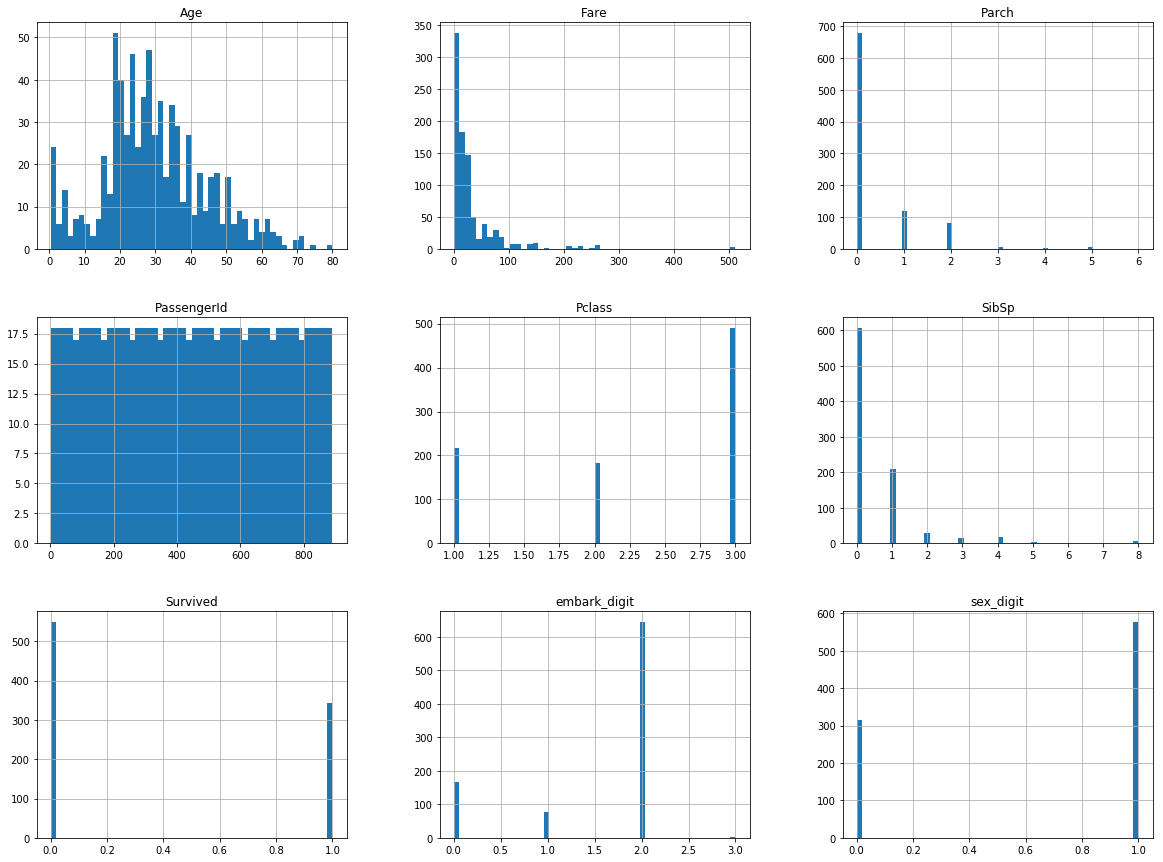

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

train_data.hist(bins=50, figsize=(20,15))
plt.show()

Most of these histograms are quite pointless on their own. I mean, just look at Passengerid. Some of these do help to give a bit more context though such as SibSp, Parch and Fare.

In [9]:
#I want to see here is embark has any correlation with class. If it does then that will help to know where to assign missing values.
pearsonr_matrix=train_data.corr()
pearsonr_matrix["embark_digit"].sort_values(ascending=False)
#Spoiler, it doesn't. Infact it only slightly has a correlation with Fare so I guess we could do something with that.

embark_digit    1.000000
Pclass          0.157112
sex_digit       0.104057
SibSp           0.066654
Parch           0.038322
PassengerId     0.013083
Age            -0.025252
Survived       -0.163517
Fare           -0.221226
Name: embark_digit, dtype: float64

In [10]:
#Let's see if there is any obvious correlation between any attributes
pearsonr_matrix["Survived"].sort_values(ascending=False)

Survived        1.000000
Fare            0.257307
Parch           0.081629
PassengerId    -0.005007
SibSp          -0.035322
Age            -0.077221
embark_digit   -0.163517
Pclass         -0.338481
sex_digit      -0.543351
Name: Survived, dtype: float64

Nothing massively obvious other than the fare and Pclass. So it could look like spending more on a ticket meant you were more likely to survive. It also looks as if being a female made you much more likely to survive too. There isn't much correlation between embark_digit and survived but it's enough to notice for now.

Let's look at some more correlations between the data as a graph and ignore the least promising ones.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025B15DEC898>,
      dtype=object)

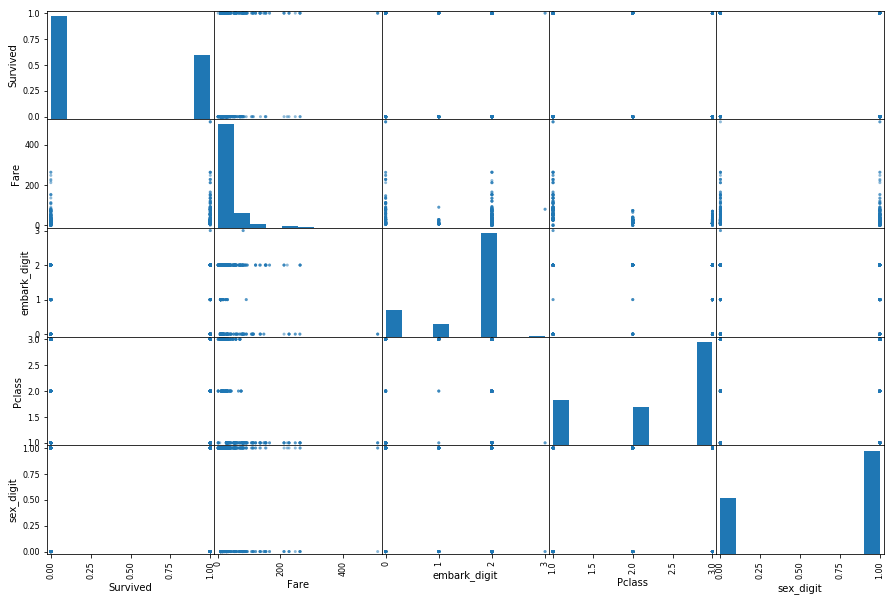

In [11]:
from pandas.plotting import scatter_matrix

#Let's take the most promising attributes
attributes = ["Survived", "Fare", "embark_digit", "Pclass", "sex_digit"]
scatter_matrix(train_data[attributes], figsize=(15,10))

That's actually awful to look at but it does kind of give a bit of a visualisation of some of the data. I think the main problem here is that a lot of the data is discrete and so they don't form a nice scatter graph. Now that I can see it, it was a bit pointless to ask for this but I think it still helps to give me mini histograms for each attribute.

The only attribute that I am unsure of dropping is either Pclass or Fare as both seem like they would do fairly similar things. Let's look at them closer.

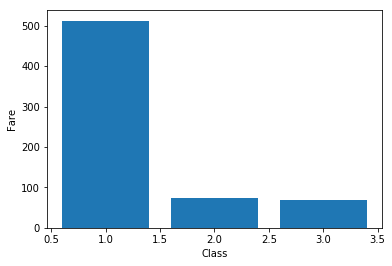

In [12]:
plt.bar(train_data["Pclass"], train_data["Fare"])
plt.xlabel("Class")
plt.ylabel("Fare")
#plt.ylim([0,100])
plt.show()

Looking at the bar chart above (even though it's not much of a help) and the earlier pearson's r correlation we know that class does have a correlation on their surival chances. And, as fare for 2nd and 3rd class is roughly the same for everyone in them then it might be better to take fare and split into 5 categories and see what effect this has. The same with age as I know it seems to have no effect this might be different if we split it into children, adults, over 60s, etc as it does have a large deviation.

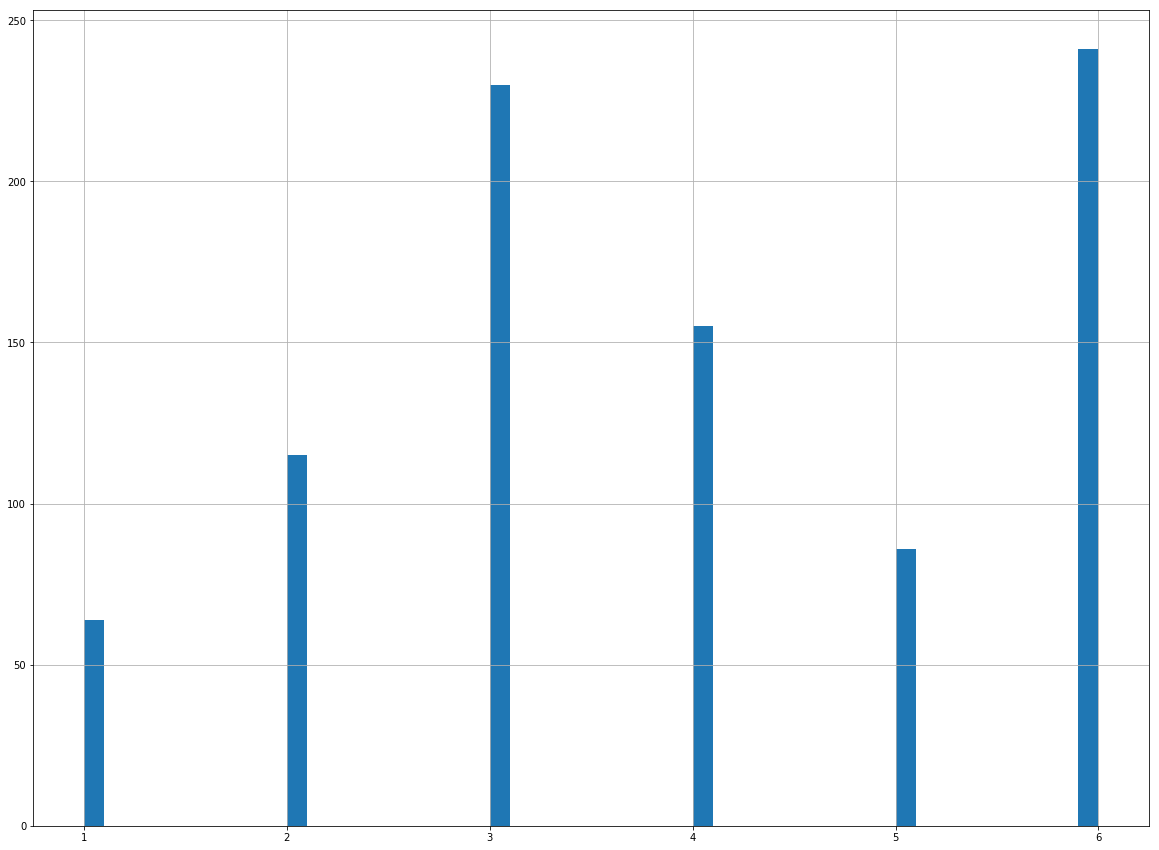

In [13]:
#First let's do age. And as some age values were missing I'm going to drop them here while I see if making it discrete will help
import numpy as np
train_data["age_category"] = np.ceil(train_data["Age"] / 10)
train_data["age_category"].where(train_data["age_category"] < 6, 6.0, inplace=True)
train_data["age_category"].hist(bins=50,figsize=(20,15))
plt.show()

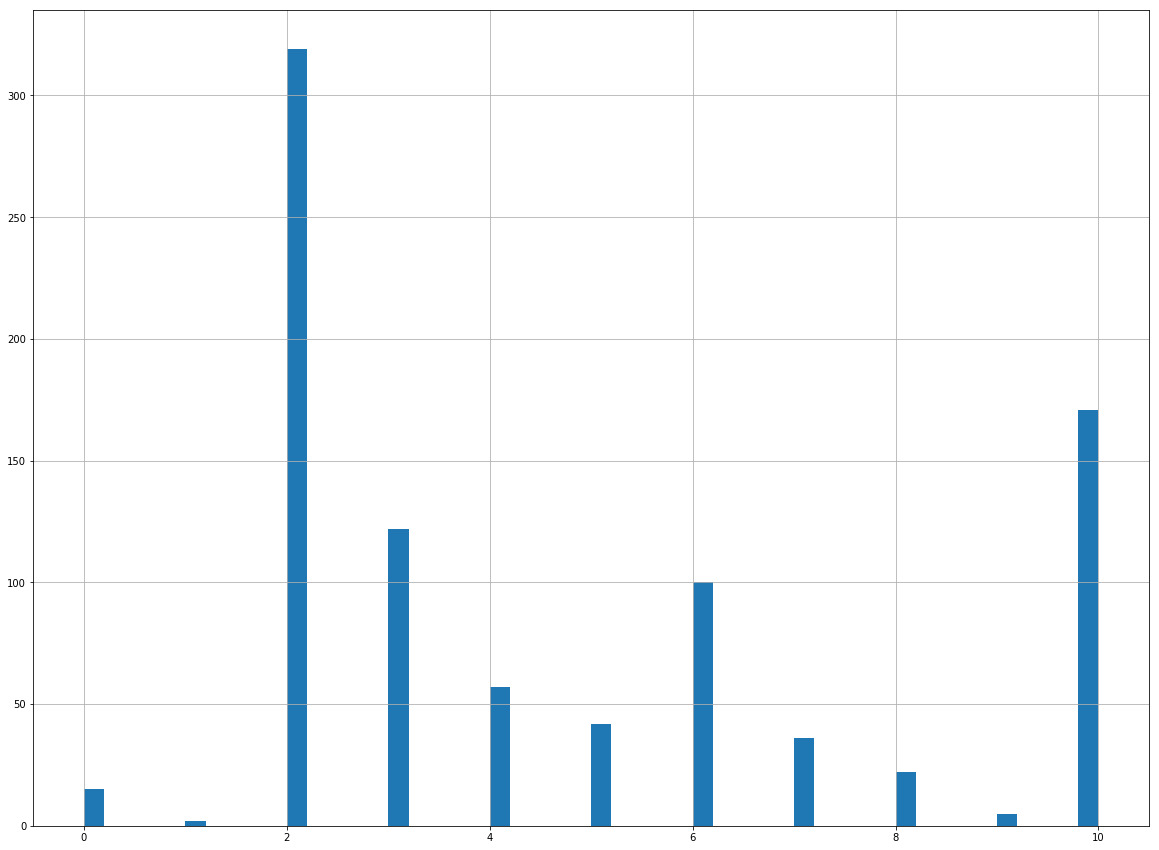

In [14]:
train_data["fare_category"] = np.ceil(train_data["Fare"] /5)
train_data["fare_category"].where(train_data["fare_category"] < 10, 10.0, inplace=True)
train_data["fare_category"].hist(bins=50,figsize=(20,15))
plt.show()

In [15]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,sex_digit,embark_digit,age_category,fare_category
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.647587,1.538721,3.905724,4.744108
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.477990,0.794231,1.610388,3.101587
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000,1.000000,3.000000,2.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,2.000000,4.000000,3.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000,2.000000,6.000000,7.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,3.000000,6.000000,10.000000


In [16]:
pearsonr_matrix=train_data.corr()
pearsonr_matrix["Survived"].sort_values(ascending=False)

Survived         1.000000
fare_category    0.317538
Fare             0.257307
Parch            0.081629
PassengerId     -0.005007
SibSp           -0.035322
Age             -0.077221
age_category    -0.104326
embark_digit    -0.163517
Pclass          -0.338481
sex_digit       -0.543351
Name: Survived, dtype: float64

So it looks like fare_category and age_category did increase their relevance. I'm going to include them in the dataset for the model and we'll see how it goes. Now we've finished exploring the data we now need to prepare it.

# Preparing the data

We're now onto preparing the data. For this we will need to reload the dataset again as I've messed with it quite a bit. Then we need to clean the data, drop and discretise certain attributes, and do any scaling necessary.

In [17]:
#So, let's reload.
train_data = load_titanic_data("train.csv")
labels = train_data["Survived"]
test_data = load_titanic_data("test.csv")

In [18]:
#Let's add back in age_category and fare_category.
def add_extra_attributes(dataset):
    dataset["fare_category"] = np.ceil(dataset["Fare"] /5)
    dataset["fare_category"].where(dataset["fare_category"] < 10, 10.0, inplace=True)
    dataset["age_category"] = np.ceil(dataset["Age"] / 10)
    dataset["age_category"].where(dataset["age_category"] < 6, 6.0, inplace=True)
    return dataset
train_data = add_extra_attributes(train_data)

In [19]:
#Now let's start making some pipelines.
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer as Imputer
from sklearn.base import BaseEstimator, TransformerMixin

#Let's make a class that selects numerical and categorical columns.
#Taken from In[110] at https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb
class DFSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
    def fit(self, x, y=None):
        return self
    def transform(self, x):
        return x[self.attributes]

In [20]:
#Now let's start with the digits.
imputer = Imputer(strategy="median")

num_pipeline = Pipeline([
    ('number_selector', DFSelector(['age_category', 'fare_category', 'SibSp', 'Parch'])),
    ('imputer', Imputer(strategy="median")),
])

In [21]:
#Now for categoricals
from sklearn.preprocessing import OneHotEncoder
imputer_cat = Imputer(strategy="most_frequent")

cat_pipeline = Pipeline([
    ('category_selector', DFSelector(['Sex', 'Embarked'])),
    ('imputer_cat', Imputer(strategy="most_frequent")),
    ('OneHot', OneHotEncoder(sparse=False)),
])

In [22]:
#Now we can run the pipelines on the training data.
num_pipeline.fit_transform(train_data)

array([[ 3.,  2.,  1.,  0.],
       [ 4., 10.,  1.,  0.],
       [ 3.,  2.,  0.,  0.],
       ...,
       [ 6.,  5.,  1.,  2.],
       [ 3.,  6.,  0.,  0.],
       [ 4.,  2.,  0.,  0.]])

In [23]:
cat_pipeline.fit_transform(train_data)

array([[0., 1., 0., 0., 1.],
       [1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0.]])

In [24]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num", num_pipeline),
    ("cat", cat_pipeline),
])

training_data_prepared = full_pipeline.fit_transform(train_data)
training_data_prepared

array([[ 3.,  2.,  1., ...,  0.,  0.,  1.],
       [ 4., 10.,  1., ...,  1.,  0.,  0.],
       [ 3.,  2.,  0., ...,  0.,  0.,  1.],
       ...,
       [ 6.,  5.,  1., ...,  0.,  0.,  1.],
       [ 3.,  6.,  0., ...,  1.,  0.,  0.],
       [ 4.,  2.,  0., ...,  0.,  1.,  0.]])

# Training models

Now we have our prepared dataset we can try out some models and select a couple of them to investigate further. I'm thinking of doing a RandomForestClassifier, a KNeighborsClassifier and maybe a SGDClassifier.

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
#Let's see how each of them compare on default values.
sgd_clf = SGDClassifier()
knn_clf = KNeighborsClassifier()
forest_clf = RandomForestClassifier()

In [26]:
sgd_score = cross_val_score(sgd_clf, training_data_prepared, labels, cv=10)
sgd_score.mean()

D:\Python\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
D:\Python\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
D:\Python\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If

0.6823638066053797

In [27]:
knn_score = cross_val_score(knn_clf, training_data_prepared, labels, cv=10)
knn_score.mean()

0.7924668028600612

In [28]:
forest_score = cross_val_score(forest_clf, training_data_prepared, labels, cv=10)
forest_score.mean()

D:\Python\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Python\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Python\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Python\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Python\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default valu

0.7980348428101236

Now we have some models that perform well enough on the training data, let's look at fine-tuning the hyper parameters.

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid =[{
    'weights': ['uniform', 'distance'], 'n_neighbors':[3,4,5,6,7,8]
}]

grid_search = GridSearchCV(knn_clf, param_grid, cv=10, scoring='accuracy', return_train_score=True, n_jobs=-1)

In [30]:
grid_search.fit(training_data_prepared, labels)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5, 6, 7, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [31]:
grid_search.best_params_

{'n_neighbors': 7, 'weights': 'uniform'}

In [32]:
param_grid_forest =[{
    'n_estimators': [25,30,35], 'max_features':[2,4,6,8,9]
}]

grid_search_forest = GridSearchCV(forest_clf, param_grid_forest, cv=10, scoring='accuracy', return_train_score=True, n_jobs=-1)

In [33]:
grid_search_forest.fit(training_data_prepared, labels)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [25, 30, 35], 'max_features': [2, 4, 6, 8, 9]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [34]:
grid_search_forest.best_params_

{'max_features': 2, 'n_estimators': 25}

Now let's look in more detail at the two classifiers' ratings.

In [35]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.001696,4.568146e-04,0.001695,0.000638,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.755556,0.800000,0.775281,...,0.856608,0.846633,0.840399,0.851621,0.849127,0.860349,0.846633,0.843088,0.849983,0.006173
1,0.001297,4.567680e-04,0.001496,0.000669,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.755556,0.777778,0.775281,...,0.891521,0.876559,0.875312,0.890274,0.889027,0.897756,0.882793,0.874222,0.885150,0.007788
2,0.001296,4.570231e-04,0.001696,0.000779,4,uniform,"{'n_neighbors': 4, 'weights': 'uniform'}",0.700000,0.777778,0.797753,...,0.851621,0.844140,0.830424,0.850374,0.844140,0.844140,0.840399,0.848070,0.844869,0.005791
3,0.001496,6.691199e-04,0.001795,0.000746,4,distance,"{'n_neighbors': 4, 'weights': 'distance'}",0.766667,0.777778,0.786517,...,0.894015,0.886534,0.881546,0.899002,0.894015,0.897756,0.887781,0.889166,0.890759,0.005560
4,0.001090,3.021606e-04,0.001496,0.000499,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.722222,0.777778,0.786517,...,0.850374,0.836658,0.835411,0.834165,0.837905,0.845387,0.835411,0.849315,0.840253,0.006282
5,0.001091,3.023462e-04,0.001595,0.000489,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.744444,0.777778,0.797753,...,0.899002,0.889027,0.891521,0.892768,0.894015,0.897756,0.890274,0.892902,0.892879,0.004351
6,0.000998,5.565938e-07,0.001396,0.000489,6,uniform,"{'n_neighbors': 6, 'weights': 'uniform'}",0.711111,0.777778,0.797753,...,0.845387,0.829177,0.835411,0.836658,0.831671,0.836658,0.829177,0.838107,0.835516,0.005035
7,0.001197,3.985883e-04,0.001296,0.000457,6,distance,"{'n_neighbors': 6, 'weights': 'distance'}",0.755556,0.733333,0.797753,...,0.899002,0.886534,0.891521,0.899002,0.892768,0.897756,0.890274,0.889166,0.893379,0.004165
8,0.001197,7.462828e-04,0.001496,0.000499,7,uniform,"{'n_neighbors': 7, 'weights': 'uniform'}",0.777778,0.766667,0.797753,...,0.836658,0.832918,0.826683,0.830424,0.827930,0.841646,0.832918,0.826899,0.832274,0.004467
9,0.000997,3.724217e-07,0.001596,0.000489,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.755556,0.766667,0.808989,...,0.899002,0.889027,0.891521,0.899002,0.894015,0.897756,0.890274,0.889166,0.893753,0.003797


In [36]:
pd.DataFrame(grid_search_forest.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.119026,0.000766,0.002085,0.000303,2,25,"{'max_features': 2, 'n_estimators': 25}",0.788889,0.755556,0.808989,...,0.897756,0.889027,0.890274,0.896509,0.892768,0.895262,0.889027,0.892902,0.893379,0.003150
1,0.121419,0.005711,0.002494,0.000669,2,30,"{'max_features': 2, 'n_estimators': 30}",0.744444,0.788889,0.797753,...,0.899002,0.889027,0.890274,0.897756,0.892768,0.896509,0.887781,0.890411,0.893379,0.003851
2,0.125353,0.008780,0.002992,0.001093,2,35,"{'max_features': 2, 'n_estimators': 35}",0.766667,0.777778,0.797753,...,0.896509,0.889027,0.891521,0.897756,0.894015,0.896509,0.889027,0.892902,0.893753,0.003129
3,0.122926,0.010022,0.001695,0.000457,4,25,"{'max_features': 4, 'n_estimators': 25}",0.777778,0.777778,0.786517,...,0.897756,0.889027,0.891521,0.899002,0.891521,0.895262,0.890274,0.892902,0.893253,0.003216
4,0.119316,0.006555,0.002493,0.000804,4,30,"{'max_features': 4, 'n_estimators': 30}",0.766667,0.788889,0.786517,...,0.897756,0.889027,0.890274,0.899002,0.892768,0.897756,0.889027,0.892902,0.893503,0.003707
5,0.115049,0.002828,0.002094,0.000299,4,35,"{'max_features': 4, 'n_estimators': 35}",0.744444,0.788889,0.797753,...,0.899002,0.886534,0.890274,0.899002,0.892768,0.897756,0.889027,0.892902,0.893628,0.004241
6,0.115048,0.000510,0.001895,0.000299,6,25,"{'max_features': 6, 'n_estimators': 25}",0.722222,0.811111,0.797753,...,0.899002,0.889027,0.890274,0.899002,0.891521,0.897756,0.890274,0.891656,0.893753,0.003677
7,0.112403,0.003474,0.001696,0.000779,6,30,"{'max_features': 6, 'n_estimators': 30}",0.766667,0.766667,0.808989,...,0.899002,0.889027,0.891521,0.899002,0.894015,0.897756,0.889027,0.891656,0.893877,0.003581
8,0.117127,0.003164,0.002294,0.000457,6,35,"{'max_features': 6, 'n_estimators': 35}",0.755556,0.777778,0.797753,...,0.899002,0.889027,0.891521,0.899002,0.890274,0.896509,0.890274,0.892902,0.893753,0.003682
9,0.113182,0.002690,0.001795,0.000399,8,25,"{'max_features': 8, 'n_estimators': 25}",0.744444,0.755556,0.797753,...,0.897756,0.889027,0.890274,0.899002,0.891521,0.894015,0.890274,0.891656,0.893004,0.003086


In [37]:
#Let's run the test set on both.
test_data_prepared = add_extra_attributes(test_data)
test_data_prepared = full_pipeline.fit_transform(test_data)

In [38]:
test_prediction_forest = grid_search_forest.best_estimator_.predict(test_data_prepared)

In [39]:
test_prediction_forest

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [40]:
#Now onto exporting the results as a csv file for submission
output_passenger_id = test_data.loc[:, 'PassengerId']
submission = pd.DataFrame(data={'PassengerId':output_passenger_id, 'Survived':test_prediction_forest})
print(submission['Survived'].value_counts())

0    258
1    160
Name: Survived, dtype: int64


In [41]:
submission.to_csv('submission.csv',index=False)

Overall the submission got 76.5% correct. For a first attempt at a challenge like this I am quite happy. I still would have prefered over 80% but I can't complain with this. 

If I were to redo this I think that I could check passenger names for titles, alter my age categories and perhaps use the SibSp and Parch data combined as I think families would be more likely to survive together or not so I could then tie this in with name.